In [1]:
#import itk
#from itk import ThinShellDemonsMetricv4 as tsd
#from itk import ConjugateGradientLineSearchOptimizerv4Template as itkc

import numpy as np
import math
import itkwidgets
from itkwidgets import view
import vtk
import matplotlib.pyplot as plt
import itk

In [ ]:
# For TSD Registration

basepath = '/media/pranjal.sahu/moredata/ITK/Modules/External/ITKThinShellDemons/test/Baseline/'
fixedMesh = itk.meshread(basepath + 'fixedMesh.vtk', itk.D)
movingMesh = itk.meshread(basepath + 'movingMesh.vtk', itk.D)

fixedMesh.BuildCellLinks()
movingMesh.BuildCellLinks()

PixelType = itk.D
Dimension = 3

MeshType = itk.Mesh[itk.D, Dimension]
FixedImageType = itk.Image[PixelType, Dimension]
MovingImageType = itk.Image[PixelType, Dimension]


# For getting the Bounding Box
ElementIdentifierType = itk.UL
CoordType = itk.F
Dimension = 3

VecContType = itk.VectorContainer[
    ElementIdentifierType, itk.Point[CoordType, Dimension]
]
bounding_box = itk.BoundingBox[ElementIdentifierType, Dimension, CoordType, VecContType].New()
bounding_box.SetPoints(movingMesh.GetPoints())
bounding_box.ComputeBoundingBox()

minBounds = np.array(bounding_box.GetMinimum())
maxBounds = np.array(bounding_box.GetMaximum())

imageDiagonal = 5
spacing = np.sqrt(bounding_box.GetDiagonalLength2()) / imageDiagonal
diff = maxBounds - minBounds

fixedImageSize = [0]*3
fixedImageSize[0] = math.ceil( 1.2 * diff[0] / spacing )
fixedImageSize[1] = math.ceil( 1.2 * diff[1] / spacing )
fixedImageSize[2] = math.ceil( 1.2 * diff[2] / spacing )

fixedImageOrigin = [0]*3
fixedImageOrigin[0] = minBounds[0] - 0.1 * diff[0]
fixedImageOrigin[1] = minBounds[1] - 0.1 * diff[1]
fixedImageOrigin[2] = minBounds[2] - 0.1 * diff[2]

fixedImageSpacing = np.ones(3)*spacing
fixedImageDirection = np.identity(3)


fixedImage = FixedImageType.New()
fixedImage.SetRegions(fixedImageSize)
fixedImage.SetOrigin( fixedImageOrigin )
fixedImage.SetDirection( fixedImageDirection )
fixedImage.SetSpacing( fixedImageSpacing )
fixedImage.Allocate()


# Affine Transform Object
TransformType = itk.AffineTransform.D3
transform = TransformType.New()
transform.SetIdentity()
transform.SetCenter(minBounds + (maxBounds - minBounds)/2)

print('Transform Created')
print(transform)


MetricType = tsd.MD3
metric = MetricType.New()
metric.SetStretchWeight(1)
metric.SetBendWeight(5)
metric.SetGeometricFeatureWeight(10)
metric.UseConfidenceWeightingOn()
metric.UseMaximalDistanceConfidenceSigmaOn()
metric.UpdateFeatureMatchingAtEachIterationOff()
metric.SetMovingTransform(transform)
# Reversed due to using points instead of an image
# to keep semantics the same as in itkThinShellDemonsTest.cxx
# For the ThinShellDemonsMetricv4 the fixed mesh is regularized
metric.SetFixedPointSet(movingMesh)
metric.SetMovingPointSet(fixedMesh)
metric.SetVirtualDomainFromImage(fixedImage)
metric.Initialize()

print('TSD Metric Created')

shiftScaleEstimator = itk.RegistrationParameterScalesFromPhysicalShift[MetricType].New()
shiftScaleEstimator.SetMetric(metric)
shiftScaleEstimator.SetVirtualDomainPointSet(metric.GetVirtualTransformedPointSet())


optimizer = itkc.D.New()
optimizer.SetNumberOfIterations( 50 )
optimizer.SetScalesEstimator( shiftScaleEstimator )
optimizer.SetMaximumStepSizeInPhysicalUnits( 0.5 )
optimizer.SetMinimumConvergenceValue( 0.0 )
optimizer.SetConvergenceWindowSize( 10 )

def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)

print('Optimizer created')


AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)

print('Registration Object created')
print('Initial Value of Metric ', metric.GetValue())

try:
    registration.Update()
except e:
    print('Error is ', e)

print('Final Value of Metric ', metric.GetValue())

finalTransform = registration.GetModifiableTransform()
numberOfPoints = movingMesh.GetNumberOfPoints()
for n in range(0, numberOfPoints):
    movingMesh.SetPoint(n, finalTransform.TransformPoint(movingMesh.GetPoint(n)))

In [3]:
itk.meshwrite(movingMesh, "affineMovingMesh.vtk")

In [1]:
moving_mesh = itk.meshread('/media/pranjal.sahu/moredata/ITKPR30/ITK/ITK-build/Wrapping/Generators/Python/movingMesh_transformed.vtk')

NameError: name 'itk' is not defined

In [11]:
# For converting from PLY to VTK

import vtk

reader = vtk.vtkPLYReader()
reader.SetFileName('/home/pranjal.sahu/Downloads/129X1_SVJ_.ply')
reader.Update()
polydata1 = reader.GetOutput()

reader1 = vtk.vtkPLYReader()
reader1.SetFileName('/home/pranjal.sahu/Downloads/129S1_SVIMJ_.ply')
reader1.Update()
polydata2 = reader1.GetOutput()

print(polydata1.GetNumberOfPoints())
print(polydata2.GetNumberOfPoints())


writer = vtk.vtkPolyDataWriter()
writer.SetFileName("/home/pranjal.sahu/Downloads/129X1_SVJ_.vtk")
writer.SetFileVersion(42)
writer.SetInputData(polydata1)
writer.Update()

writer = vtk.vtkPolyDataWriter()
writer.SetFileName("/home/pranjal.sahu/Downloads/129S1_SVIMJ_.vtk")
writer.SetFileVersion(42)
writer.SetInputData(polydata2)
writer.Update()

169954
174916


In [25]:
# [STAR] Garbage

import vtk

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITKPR30/ITK/ITK-build/Wrapping/Generators/Python/movingMesh_transformed.vtk')
reader.Update()
polydata1 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/home/pranjal.sahu/Downloads/129X1_SVJ_.vtk')
reader.Update()
polydata2 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/home/pranjal.sahu/Downloads/129S1_SVIMJ_.vtk')
reader.Update()
polydata3 = reader.GetOutput()



reader = vtk.vtkPLYReader()
reader.SetFileName('A_J_skull_temp1.ply')
reader.Update()
polydata4 = reader.GetOutput()


reader = vtk.vtkPLYReader()
reader.SetFileName('NOD_SHILTJ_temp1.ply')
reader.Update()
polydata5 = reader.GetOutput()


In [13]:
# For reducing the mesh sizes 

reader = vtk.vtkPolyDataReader()
reader.SetFileName('A_J_skull_.vtk')
reader.Update()
polydata4 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('NOD_SHILTJ_.vtk')
reader.Update()
polydata5 = reader.GetOutput()

print('Before number of points')
print(polydata4.GetNumberOfPoints())
print(polydata5.GetNumberOfPoints())

f = vtk.vtkDecimatePro()
f.SetTargetReduction(0.95)
f.SetInputData(polydata4)
f.Update()
polydata4 = f.GetOutput()


f = vtk.vtkDecimatePro()
f.SetTargetReduction(0.95)
f.SetInputData(polydata5)
f.Update()
polydata5 = f.GetOutput()

print('After number of points')
print(polydata4.GetNumberOfPoints())
print(polydata5.GetNumberOfPoints())

Before number of points
156161
190584
After number of points
21397
26620


In [15]:
# For cleaning the mesh

gfilter1 = vtk.vtkTriangleFilter()
gfilter1.SetInputData(polydata4)
gfilter1.SetPassLines(False)
gfilter1.SetPassVerts(False)
gfilter1.Update()
polydata4 = gfilter1.GetOutput()

# cleaner = vtk.vtkCleanPolyData()
# cleaner.SetInputData(polydata4)
# cleaner.SetTolerance(0.0001)
# cleaner.Update()
# polydata4 = cleaner.GetOutput()


w = vtk.vtkPolyDataWriter()
w.SetFileName('A_J_skull_95.vtk')
w.SetFileVersion(42)
w.SetInputData(polydata4)
w.Update()

gfilter1 = vtk.vtkTriangleFilter()
gfilter1.SetInputData(polydata5)
gfilter1.SetPassLines(False)
gfilter1.SetPassVerts(False)
gfilter1.Update()
polydata5 = gfilter1.GetOutput()

# cleaner = vtk.vtkCleanPolyData()
# cleaner.SetInputData(polydata5)
# cleaner.SetTolerance(0.0001)
# cleaner.Update()
# polydata5 = cleaner.GetOutput()


w = vtk.vtkPolyDataWriter()
w.SetFileName('NOD_SHILTJ_95.vtk')
w.SetFileVersion(42)
w.SetInputData(polydata5)
w.Update()

print(polydata4.GetNumberOfPoints())
print(polydata5.GetNumberOfPoints())

21397
26620


In [24]:
print(polydata4.GetBounds())
print(polydata5.GetBounds())



(1.0, -1.0, 1.0, -1.0, 1.0, -1.0)
(1.0, -1.0, 1.0, -1.0, 1.0, -1.0)


In [36]:
a = 17.8286 - 3.23437
b = 19.0109 - 1.81288
c = 18.197 - 0.784033

print(a, b, c)

14.594230000000001 17.19802 17.412967


(186793, 3)


(array([ 5187.,  9162.,  9864., 11144., 21413., 44660., 42279., 26257.,
        14912.,  1915.]),
 array([ 3.23437 ,  4.693793,  6.153216,  7.612639,  9.072062, 10.531485,
        11.990908, 13.450331, 14.909754, 16.369177, 17.8286  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

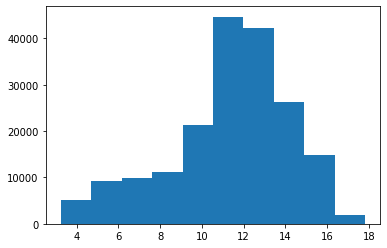

In [32]:
from vtk.util import numpy_support
import matplotlib.pyplot as plt

p1 = numpy_support.vtk_to_numpy(polydata5.GetPoints().GetData())
print(p1.shape)

plt.hist(p1[:, 0])

In [53]:
# [STAR] For testing on ALPACA sample

#reader = vtk.vtkPLYReader()
reader = vtk.vtkPolyDataReader()
reader.SetFileName('A_J_skull_.vtk')
reader.Update()
polydata4 = reader.GetOutput()

#reader = vtk.vtkPLYReader()
reader = vtk.vtkPolyDataReader()
reader.SetFileName('NOD_SHILTJ_.vtk')
reader.Update()
polydata5 = reader.GetOutput()

# reader = vtk.vtkPolyDataReader()
# reader.SetFileName('/home/pranjal.sahu/SlicerMorph/displacementMovingMesh.vtk')
# reader.Update()
# polydata6 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('WarpedSourceMesh.vtk')
reader.Update()
polydata7 = reader.GetOutput()

#print(polydata4.GetNumberOfPoints())
print(polydata4.GetNumberOfPoints())
print(polydata5.GetNumberOfPoints())
print(polydata7.GetNumberOfPoints())

#view(geometries=[polydata4,  polydata5, polydata6, polydata7])
#view(geometries=[polydata4,  polydata5, polydata6])
view(geometries=[polydata4, polydata5, polydata7])
#view(geometries=[polydata4,  polydata7])

156161
190584
157212


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [2]:
# reader = vtk.vtkPolyDataReader()
# reader.SetFileName('NOD_SHILTJ_.vtk')
# reader.Update()
# polydata5 = reader.GetOutput()

# reader = vtk.vtkPolyDataReader()
# reader.SetFileName('WarpedSourceMesh.vtk')
# reader.Update()
# polydata7 = reader.GetOutput()
import itk

fixedMesh = itk.meshread('NOD_SHILTJ_.vtk')
movingMesh = itk.meshread('WarpedSourceMesh.vtk')

fixedPS = itk.PointSet.D3.New()
movingPS = itk.PointSet.D3.New()

fixedPS.SetPoints(fixedMesh.GetPoints())
movingPS.SetPoints(movingMesh.GetPoints())

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedPS)
e_metric.SetMovingPointSet(movingPS)
print('Final Euclidean Metric 2 ', e_metric.GetValue())

Final Euclidean Metric 2  0.11508942417020142


In [40]:
# [STAR] For testing on the ThinShell sample

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/Modules/External/ITKThinShellDemons/test/Baseline/fixedMesh.vtk')
reader.Update()
polydata4 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/Modules/External/ITKThinShellDemons/test/Baseline/movingMesh.vtk')
reader.Update()
polydata5 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/ITK-build/bin/displacedMovingMesh.vtk')
reader.Update()
polydata6 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/ITK-build/bin/displacedMovingMesh1.vtk')
reader.Update()
polydata7 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('/media/pranjal.sahu/moredata/ITK/ITK-build/Wrapping/Generators/Python/affineMovingMesh.vtk')
reader.Update()
polydata8 = reader.GetOutput()


#print(polydata4.GetNumberOfPoints())
print(polydata4.GetNumberOfPoints())
print(polydata6.GetNumberOfPoints())
print(polydata8.GetNumberOfPoints())
#print(polydata7.GetNumberOfPoints())

#view(geometries=[polydata4,  polydata5, polydata6, polydata7])
#view(geometries=[polydata4,  polydata5, polydata6])
#view(geometries=[polydata4, polydata5, polydata6, polydata7])
#view(geometries=[polydata4,  polydata7])

view(geometries=[polydata4, polydata5, polydata8])

830
938
938


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [36]:
reader = vtk.vtkPolyDataReader()
reader.SetFileName('NOD_SHILTJ_temp5.vtk')
reader.Update()
polydata7 = reader.GetOutput()

writer = vtk.vtkPLYWriter()
writer.SetFileName('NOD_SHILTJ_temp5.ply')
writer.SetInputData(polydata7)
writer.Update()

In [10]:
reader = vtk.vtkPolyDataReader()
reader.SetFileName('A_J_skull_temp5.vtk')
reader.Update()
polydata7 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
reader.SetFileName('NOD_SHILTJ_temp5.vtk')
reader.Update()
polydata8 = reader.GetOutput()

reader = vtk.vtkPolyDataReader()
#reader.SetFileName('/home/pranjal.sahu/SlicerMorph/allmeshresults/displacementMovingMesh_600-0.001-0.001-0.001-0.001-0.07106161032147815.vtk')
#reader.SetFileName('/home/pranjal.sahu/SlicerMorph/allmeshresults/displacementMovingMesh_700-0.001-0.001-0.001-0.001-0.08031471544874559.vtk')
#reader.SetFileName('/home/pranjal.sahu/SlicerMorph/allmeshresults/displacementMovingMesh_800-0.001-0.001-0.001-0.001-0.08250421639924699.vtk')
#reader.SetFileName('/home/pranjal.sahu/SlicerMorph/allmeshresults/displacementMovingMesh_800-0.001-0.001-0.001-0.001-0.08186036051193908.vtk')
#reader.SetFileName('/media/pranjal.sahu/moredata/ITK/ITK-build/Wrapping/Generators/Python/allmeshresults/displacementMovingMesh_800-0.001-0.001-0.001-0.001-0.08250421639924699.vtk')
#reader.SetFileName('/media/pranjal.sahu/moredata/ITK/ITK-build/Wrapping/Generators/Python/allmeshresults/displacementMovingMesh_800-0.004-0.004-0.006-0.001-0.10854185643814045.vtk')
#reader.SetFileName('displacementMovingMesh_reverse_800-0.002-0.002-0.001-0.002-0.11736897839342039.vtk')
#reader.SetFileName('displacementMovingMesh_reverse_1000-0.001-0.001-0.001-0.0005-0.10660825724771353.vtk')
#reader.SetFileName('./allmeshresults/displacementMovingMesh_reverse_400-0.01-0.01-0.001-0.01-0.12091795786630977.vtk')
#reader.SetFileName('result.vtk')
reader.SetFileName('/media/pranjal.sahu/moredata/ITKPR21/ITK/ITK-build/bin/affineMovingMesh.vtk')
reader.Update()
polydata9 = reader.GetOutput()


reader = vtk.vtkPolyDataReader()
reader.SetFileName('WarpedSourceMesh_temp5.vtk')
reader.Update()
polydata10 = reader.GetOutput()


print(polydata7.GetNumberOfPoints())
print(polydata8.GetNumberOfPoints())
print(polydata9.GetNumberOfPoints())
#print(polydata10.GetNumberOfPoints())

#view(geometries=[polydata7, polydata8, polydata9, polydata10])
#view(geometries=[polydata8, polydata9, polydata10])
#view(geometries=[polydata7, polydata8, polydata9, polydata10])
view(geometries=[polydata8, polydata9])

63676
80934
80934


Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [27]:
a = np.load('displacement_field.npy')
print(a.shape)

(74, 73, 62, 3)


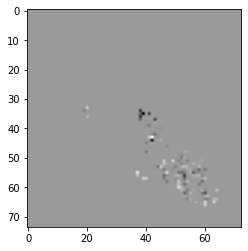

In [34]:
plt.imshow(a[:, :, 45, 0], cmap='gray')

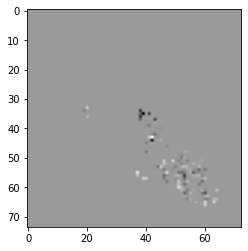

In [33]:
plt.imshow(a[:, :, 45, 0], cmap='gray')

In [7]:
# [STAR] For comparing the Euclidean distance of original meshes

fixedMesh = itk.meshread('A_J_skull_temp5.vtk', itk.D)
movingMesh = itk.meshread('NOD_SHILTJ_temp5.vtk', itk.D)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Final Euclidean Metric 2 ', e_metric.GetValue())

Final Euclidean Metric 2  0.1495193781721138


In [ ]:
# [STAR] For using the ProcrustesAlignFilter

# Get mean mesh
FilterType = itk.MeshProcrustesAlignFilter[type(fixedMesh), type(fixedMesh)]
filter1 = FilterType.New();

filter1.SetNumberOfInputs(2);
filter1.SetInput(0, fixedMesh);
filter1.SetInput(1, movingMesh);

# Set application-specific parameters
filter1.SetConvergence(50.0);
filter1.SetUseInitialAverageOff();
filter1.SetUseNormalizationOff();
filter1.SetUseScalingOff();

# Run a single iteration to show that registration executes
filter1.SetUseSingleIterationOn();
filter1.Update();


In [125]:
# [STAR] For comparing the Euclidean distance of the outputs

fixedMesh = itk.meshread('A_J_skull_temp5.vtk', itk.D)
#movingMesh = itk.meshread('/media/pranjal.sahu/moredata/ITK/ITK-build/bin/synMovingMesh.vtk', itk.D)
movingMesh = itk.meshread('/media/pranjal.sahu/moredata/ITK/ITK-build/bin/synMovingMesh.vtk', itk.D)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Final Euclidean Metric 2 ', e_metric.GetValue())

Final Euclidean Metric 2  0.14826701869407985


In [114]:
# [STAR] For comparing the Euclidean distance of the outputs

fixedMesh = itk.meshread('NOD_SHILTJ_temp5.vtk', itk.D)
movingMesh = itk.meshread('WarpedSourceMesh_temp5.vtk', itk.D)

e_metric = itk.EuclideanDistancePointSetToPointSetMetricv4.PSD3.New()
e_metric.SetFixedPointSet(fixedMesh)
e_metric.SetMovingPointSet(movingMesh)
print('Final Euclidean Metric 2 ', e_metric.GetValue())

Final Euclidean Metric 2  0.14203660580922842


In [91]:
field = np.load('/media/pranjal.sahu/moredata/ITK/ITK-build/Wrapping/Generators/Python/displacement_field.npy')
print(field.shape)

(37, 37, 31, 3)


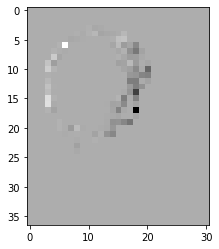

In [92]:
plt.imshow(field[12, :, :, 0], cmap='gray')

In [8]:
# For ICP registration

Dimension = 3

PointSetType = itk.PointSet[itk.F, Dimension]

fixedMesh = itk.meshread('/home/pranjal.sahu/Downloads/129X1_SVJ_.vtk')
movingMesh = itk.meshread('/home/pranjal.sahu/Downloads/129S1_SVIMJ_.vtk')

fixedPS = PointSetType.New()
movingPS = PointSetType.New()

fixedPS.SetPoints(fixedMesh.GetPoints())
movingPS.SetPoints(movingMesh.GetPoints())

print(fixedMesh.GetNumberOfPoints(), movingMesh.GetNumberOfPoints())
print(fixedPS.GetNumberOfPoints(), movingPS.GetNumberOfPoints())

169954 174916
169954 174916


In [35]:
OptimizerType    = itk.LevenbergMarquardtOptimizer
MetricType       = itk.EuclideanDistancePointSetToPointSetMetricv4[type(fixedPS)]
#MetricType       = itk.EuclideanDistanceMetricv[type(fixedPS)]
TransformType    = itk.Rigid3DTransform[itk.D]
RegistrationType = itk.PointSetToPointSetRegistrationMethod[PointSetType, PointSetType]

#print(MetricType)

In [23]:
metric       = MetricType.New()
transform    = TransformType.New()
optimizer    = OptimizerType.New()
registration = RegistrationType.New()

In [24]:
numberOfIterations = 100
gradientTolerance  = 1e-5
valueTolerance     = 1e-5   
epsilonFunction    = 1e-6

#optimizer.SetScales(scales)
optimizer.SetNumberOfIterations(numberOfIterations)
optimizer.SetValueTolerance(valueTolerance)
optimizer.SetGradientTolerance(gradientTolerance)
optimizer.SetEpsilonFunction(epsilonFunction)

In [31]:
metric.SetFixedPointSet(fixedPS)
metric.SetMovingPointSet(movingPS)
metric.SetMovingTransform(TransformType)
metric.Initialize()

TypeError: in method 'itkObjectToObjectMetric33_SetMovingTransform', argument 2 of type 'itkTransformD33 *'

In [33]:
AffineRegistrationType = itk.ImageRegistrationMethodv4.REGv4D3D3TD3D3MD3.New()
registration = AffineRegistrationType.New()
registration.SetNumberOfLevels(1)
registration.SetObjectName("registration")
registration.SetFixedPointSet(movingMesh)
registration.SetMovingPointSet(fixedMesh)
registration.SetInitialTransform(transform)
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)

itk.itkRigid3DTransformPython.itkRigid3DTransformD

In [25]:
def iteration_update():
    metric_value = optimizer.GetValue()
    current_parameters = optimizer.GetCurrentPosition()
    print(f"Metric: {metric_value:.8g}")

iteration_command = itk.PyCommand.New()
iteration_command.SetCommandCallable(iteration_update)
optimizer.AddObserver(itk.IterationEvent(), iteration_command)


transform.SetIdentity()
registration.SetInitialTransformParameters(transform.GetParameters())
registration.SetMetric(metric)
registration.SetOptimizer(optimizer)
registration.SetTransform(transform)
registration.SetFixedPointSet(fixedPointSet)
registration.SetMovingPointSet(movingPointSet)
registration.Update()

TypeError: in method 'itkPointSetToPointSetRegistrationMethodREGF3F3_SetMetric', argument 2 of type 'itkPointSetToPointSetMetricPSF3 *'

In [28]:
registration.SetMetric(metric)

TypeError: in method 'itkPointSetToPointSetRegistrationMethodREGF3F3_SetMetric', argument 2 of type 'itkPointSetToPointSetMetricPSF3 *'

In [29]:
type(metric)

itk.itkEuclideanDistancePointSetToPointSetMetricPython.itkEuclideanDistancePointSetToPointSetMetricv4PSF3

In [30]:
type(registration)

itk.itkPointSetToPointSetRegistrationMethodPython.itkPointSetToPointSetRegistrationMethodREGF3F3

In [23]:
# [STAR] VTK based point cloud alignment

import vtkmodules.vtkInteractionStyle
# noinspection PyUnresolvedReferences
import vtkmodules.vtkRenderingOpenGL2
from vtkmodules.vtkCommonColor import vtkNamedColors
from vtkmodules.vtkCommonCore import (
    VTK_DOUBLE_MAX,
    vtkPoints
)
from vtkmodules.vtkCommonDataModel import (
    vtkIterativeClosestPointTransform,
    vtkPolyData
)
from vtkmodules.vtkCommonTransforms import (
    vtkLandmarkTransform,
    vtkTransform
)
from vtkmodules.vtkFiltersGeneral import (
    vtkOBBTree,
    vtkTransformPolyDataFilter
)
from vtkmodules.vtkFiltersModeling import vtkHausdorffDistancePointSetFilter
from vtkmodules.vtkIOGeometry import (
    vtkBYUReader,
    vtkOBJReader,
    vtkSTLReader
)
from vtkmodules.vtkIOPLY import vtkPLYReader
from vtkmodules.vtkRenderingCore import (
    vtkActor,
    vtkDataSetMapper,
    vtkRenderWindow,
    vtkRenderWindowInteractor,
    vtkRenderer
)


def ReadPolyData(file_name):
    import os
    path, extension = os.path.splitext(file_name)
    extension = extension.lower()
    if extension == ".ply":
        reader = vtkPLYReader()
        reader.SetFileName(file_name)
        reader.Update()
        poly_data = reader.GetOutput()
    elif extension == ".vtp":
        reader = vtkXMLpoly_dataReader()
        reader.SetFileName(file_name)
        reader.Update()
        poly_data = reader.GetOutput()
    elif extension == ".obj":
        reader = vtkOBJReader()
        reader.SetFileName(file_name)
        reader.Update()
        poly_data = reader.GetOutput()
    elif extension == ".stl":
        reader = vtkSTLReader()
        reader.SetFileName(file_name)
        reader.Update()
        poly_data = reader.GetOutput()
    elif extension == ".vtk":
        reader = vtk.vtkPolyDataReader()
        reader.SetFileName(file_name)
        reader.Update()
        poly_data = reader.GetOutput()
    elif extension == ".g":
        reader = vtkBYUReader()
        reader.SetGeometryFileName(file_name)
        reader.Update()
        poly_data = reader.GetOutput()
    else:
        # Return a None if the extension is unknown.
        poly_data = None
    return poly_data

def AlignBoundingBoxes(source, target):
    # Use OBBTree to create an oriented bounding box for target and source
    sourceOBBTree = vtkOBBTree()
    sourceOBBTree.SetDataSet(source)
    sourceOBBTree.SetMaxLevel(1)
    sourceOBBTree.BuildLocator()

    targetOBBTree = vtkOBBTree()
    targetOBBTree.SetDataSet(target)
    targetOBBTree.SetMaxLevel(1)
    targetOBBTree.BuildLocator()

    sourceLandmarks = vtkPolyData()
    sourceOBBTree.GenerateRepresentation(0, sourceLandmarks)

    targetLandmarks = vtkPolyData()
    targetOBBTree.GenerateRepresentation(0, targetLandmarks)

    lmTransform = vtkLandmarkTransform()
    lmTransform.SetModeToSimilarity()
    lmTransform.SetTargetLandmarks(targetLandmarks.GetPoints())
    # lmTransformPD = vtkTransformPolyDataFilter()
    bestDistance = VTK_DOUBLE_MAX
    bestPoints = vtkPoints()
    bestDistance = BestBoundingBox(
        "X",
        target,
        source,
        targetLandmarks,
        sourceLandmarks,
        bestDistance,
        bestPoints)
    bestDistance = BestBoundingBox(
        "Y",
        target,
        source,
        targetLandmarks,
        sourceLandmarks,
        bestDistance,
        bestPoints)
    bestDistance = BestBoundingBox(
        "Z",
        target,
        source,
        targetLandmarks,
        sourceLandmarks,
        bestDistance,
        bestPoints)

    lmTransform.SetSourceLandmarks(bestPoints)
    lmTransform.Modified()

    transformPD = vtkTransformPolyDataFilter()
    transformPD.SetInputData(source)
    transformPD.SetTransform(lmTransform)
    transformPD.Update()

    source.DeepCopy(transformPD.GetOutput())

    return

def BestBoundingBox(axis, target, source, targetLandmarks, sourceLandmarks, bestDistance, bestPoints):
    distance = vtkHausdorffDistancePointSetFilter()
    testTransform = vtkTransform()
    testTransformPD = vtkTransformPolyDataFilter()
    lmTransform = vtkLandmarkTransform()
    lmTransformPD = vtkTransformPolyDataFilter()

    lmTransform.SetModeToSimilarity()
    lmTransform.SetTargetLandmarks(targetLandmarks.GetPoints())

    sourceCenter = sourceLandmarks.GetCenter()

    delta = 90.0
    for i in range(0, 4):
        angle = delta * i
        # Rotate about center
        testTransform.Identity()
        testTransform.Translate(sourceCenter[0], sourceCenter[1], sourceCenter[2])
        if axis == "X":
            testTransform.RotateX(angle)
        elif axis == "Y":
            testTransform.RotateY(angle)
        else:
            testTransform.RotateZ(angle)
        testTransform.Translate(-sourceCenter[0], -sourceCenter[1], -sourceCenter[2])

        testTransformPD.SetTransform(testTransform)
        testTransformPD.SetInputData(sourceLandmarks)
        testTransformPD.Update()

        lmTransform.SetSourceLandmarks(testTransformPD.GetOutput().GetPoints())
        lmTransform.Modified()

        lmTransformPD.SetInputData(source)
        lmTransformPD.SetTransform(lmTransform)
        lmTransformPD.Update()

        distance.SetInputData(0, target)
        distance.SetInputData(1, lmTransformPD.GetOutput())
        distance.Update()

        testDistance = distance.GetOutput(0).GetFieldData().GetArray("HausdorffDistance").GetComponent(0, 0)
        if testDistance < bestDistance:
            bestDistance = testDistance
            bestPoints.DeepCopy(testTransformPD.GetOutput().GetPoints())

    return bestDistance

src_fn = '/home/pranjal.sahu/Downloads/A_J_skull_.ply'
tgt_fn = '/home/pranjal.sahu/Downloads/B6129PF1_J_.ply'

sourcePolyData = ReadPolyData(src_fn)

# Save the source polydata in case the align does not improve
# segmentation
originalSourcePolyData = vtkPolyData()
originalSourcePolyData.DeepCopy(sourcePolyData)

print('Loading target:', tgt_fn)
targetPolyData = ReadPolyData(tgt_fn)

# If the target orientation is markedly different,
# you may need to apply a transform to orient the
# target with the source.
# For example, when using Grey_Nurse_Shark.stl as the source and
# greatWhite.stl as the target, you need to uncomment the following
# two rotations.
trnf = vtkTransform()
trnf.RotateX(90)
#trnf.RotateY(-90)
tpd = vtkTransformPolyDataFilter()
tpd.SetTransform(trnf)
tpd.SetInputData(targetPolyData)
tpd.Update()

renderer = vtkRenderer()
renderWindow = vtkRenderWindow()
renderWindow.AddRenderer(renderer)
interactor = vtkRenderWindowInteractor()
interactor.SetRenderWindow(renderWindow)

distance = vtkHausdorffDistancePointSetFilter()
distance.SetInputData(0, tpd.GetOutput())
distance.SetInputData(1, sourcePolyData)
distance.Update()

distanceBeforeAlign = distance.GetOutput(0).GetFieldData().GetArray('HausdorffDistance').GetComponent(0, 0)

# Get initial alignment using oriented bounding boxes
AlignBoundingBoxes(sourcePolyData, tpd.GetOutput())

distance.SetInputData(0, tpd.GetOutput())
distance.SetInputData(1, sourcePolyData)
distance.Modified()
distance.Update()
distanceAfterAlign = distance.GetOutput(0).GetFieldData().GetArray('HausdorffDistance').GetComponent(0, 0)

bestDistance = min(distanceBeforeAlign, distanceAfterAlign)


print('Distance after bounding box alignment ', bestDistance)
if distanceAfterAlign > distanceBeforeAlign:
    sourcePolyData.DeepCopy(originalSourcePolyData)

# Refine the alignment using IterativeClosestPoint
icp = vtkIterativeClosestPointTransform()
icp.SetSource(sourcePolyData)
icp.SetTarget(tpd.GetOutput())
icp.GetLandmarkTransform().SetModeToRigidBody()
icp.SetMaximumNumberOfLandmarks(500)
icp.SetMaximumMeanDistance(.00001)
icp.SetMaximumNumberOfIterations(100)
icp.CheckMeanDistanceOn()
icp.StartByMatchingCentroidsOn()
icp.Update()

#print(icp)

lmTransform = icp.GetLandmarkTransform()
transform = vtkTransformPolyDataFilter()
transform.SetInputData(sourcePolyData)
transform.SetTransform(lmTransform)
transform.SetTransform(icp)
transform.Update()

distance.SetInputData(0, tpd.GetOutput())
distance.SetInputData(1, transform.GetOutput())
distance.Update()

distanceAfterICP = distance.GetOutput(0).GetFieldData().GetArray('HausdorffDistance').GetComponent(0, 0)

if distanceAfterICP < bestDistance:
    bestDistance = distanceAfterICP

print('Best Distance ', bestDistance)

Loading target: /home/pranjal.sahu/Downloads/B6129PF1_J_.ply
Distance after bounding box alignment  1.543693709016135
Best Distance  0.7534908978451943


In [24]:
view(geometries=[tpd.GetOutput(),  transform.GetOutput()])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [9]:
import itk
import vtk

reader = vtk.vtkPLYReader()
reader.SetFileName('/home/pranjal.sahu/Downloads/A_J_skull_.ply')
reader.Update()
a = reader.GetOutput()
        

reader = vtk.vtkPLYReader()
reader.SetFileName('/home/pranjal.sahu/Downloads/B6129SF1_J_.ply')
reader.Update()
b = reader.GetOutput()

#a = itk.meshread('/home/pranjal.sahu/SlicerMorph/A_J_skull_.vtk')
#b = itk.meshread('/home/pranjal.sahu/SlicerMorph/NOD_SHILTJ_.vtk')

#print(b)
view(geometries=[a, b])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

In [18]:
view(geometries=[tpd.GetOutput(), transform.GetOutput()])

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…